In [1]:
! which python

/Users/no_lineal/opt/anaconda3/envs/grid38/bin/python


In [2]:
import numpy as np
import random

from scipy.ndimage import gaussian_filter

from scipy.ndimage import maximum_filter

import cv2 as cv

from tqdm import tqdm

import os

# viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [3]:
""" 

    where am i?

"""

PATH = os.getcwd()
data_path = PATH.replace( '01_square_70_256', '' ) + 'data/01_square/01_square_1000000_70_256/'

print( f'PATH: { PATH }' )
print( f'data_path: { data_path }' )

PATH: /Users/no_lineal/Documents/draft_code/grid_metrics/01_square_70_256
data_path: /Users/no_lineal/Documents/draft_code/grid_metrics/data/01_square/01_square_1000000_70_256/


In [4]:
""" 

    load data

"""

ratemap_mat = np.load( data_path + 'grid_scores/ratemap.npy' )
#sample_idx = np.random.randint( 0, ratemap_mat.shape[0] )
#sample_idx = 15
#ratemap_mat = np.array([ ratemap_mat[ sample_idx ] ])

print( f'ratemap_mat.shape: { ratemap_mat.shape }' )

ratemap_mat.shape: (512, 32, 32)


In [5]:
""" 

    field shuffling

"""

def normalize_ratemap( ratemap ):
    
    min_val = np.min( ratemap )
    max_val = np.max( ratemap )

    return 255 * ( ratemap - min_val ) / ( max_val - min_val )

def peak_filter( sac, hc_centre=True, footprint=( 5, 5 ) ):

    if hc_centre:

        centre = sac.shape[0] // 2
        global_max_pos = ( centre, centre )

    else:

        global_max_pos = np.unravel_index( np.argmax( sac ), sac.shape )

    local_max_pos = maximum_filter( sac, footprint=np.ones( footprint ), mode='wrap' )
    dists = [ np.linalg.norm( np.array( global_max_pos ) - np.array( pos ) ) for pos in np.argwhere( local_max_pos == sac ) ]

    local_max_pos = np.argwhere( local_max_pos == sac )

    return global_max_pos, local_max_pos, dists

def get_neighbours( r, c ):

    return [(r-1, c), (r+1, c), (r, c-1), (r, c+1)]

def is_valid( r, c, shape ):

    return 0 <= r < shape[0] and 0 <= c < shape[1]

def toroidal_pos(pos, shape):
    return (pos[0] % shape[0], pos[1] % shape[1])

def randomize_fields( ratemap_ss, markers, local_max_pos ):

    pos_label = [ markers[ pos[0], pos[1] ] for pos in local_max_pos ]

    aux_local_max_pos = []
    aux_pos_label = []
    for i, l in enumerate( pos_label ):

        if (l not in aux_pos_label) and (l != 0):
        #if l not in aux_pos_label:
            aux_local_max_pos.append( local_max_pos[i] )
            aux_pos_label.append( l )
    
    # fields list dict
    fields = []
    #for pos in local_max_pos:
    for pos in aux_local_max_pos:

        fields.append( {
            'peak': tuple(pos),
            'bins': [ tuple(x) for x in np.argwhere( markers == markers[ pos[0], pos[1] ] ) ]
        } )

    shuffled_ratemap = np.full_like( ratemap_ss, np.nan )
    shape = ratemap_ss.shape
    
    np.random.shuffle( fields )

    for field in fields:

        peak = field['peak']
        bins = field['bins']

        if np.isnan( shuffled_ratemap ).all():

            random_peak_pos = (np.random.randint(0, shape[0] - 1), np.random.randint(0, shape[1] - 1))

            while not np.isnan(shuffled_ratemap[random_peak_pos]):
                random_peak_pos = (np.random.randint(0, shape[0] - 1), np.random.randint(0, shape[1] - 1))

        else:

            # find current max peak
            current_max_peak = np.unravel_index( np.argmax( shuffled_ratemap ), shape )

            # move peak to a random position as far as possible from the current max peak
            min_distance = shape[ 0 ] / 2
            random_peak_pos = (np.random.randint(0, shape[0]), np.random.randint(0, shape[1]))

            # while distance is less than min_distance
            while np.linalg.norm( np.array( current_max_peak ) - np.array( random_peak_pos ) ) < min_distance:

                random_peak_pos = (np.random.randint(0, shape[0]), np.random.randint(0, shape[1]))

        shuffled_ratemap[random_peak_pos] = ratemap_ss[peak]

        relative_pos = {bin_pos: (bin_pos[0] - peak[0], bin_pos[1] - peak[1]) for bin_pos in bins if bin_pos != peak}

        for bin_pos, rel_pos in relative_pos.items():
            
            new_pos = (random_peak_pos[0] + rel_pos[0], random_peak_pos[1] + rel_pos[1])
            new_pos = toroidal_pos(new_pos, shape)

            if is_valid(new_pos[0], new_pos[1], shape):
                shuffled_ratemap[new_pos] = ratemap_ss[bin_pos]

    mask = np.full_like( ratemap_ss, np.nan )

    for l in np.unique(markers):
        if l not in aux_pos_label:
            mask[ markers == l ] = ratemap_ss[ markers == l ]

    # flatten mask
    mask_flat = mask.flatten()
    mask_flat = list(mask_flat[~np.isnan(mask_flat)])
    mask_flat = sorted(mask_flat, key=lambda x: random.random())

    if len( mask_flat ) > 0:

        if len(mask_flat) < np.isnan(shuffled_ratemap).sum():

            diff = np.isnan(shuffled_ratemap).sum() - len(mask_flat)
            diff_array = np.random.uniform( low=np.min( mask_flat ), high=np.max( mask_flat ), size=diff )
            mask_flat.extend( diff_array )

        for i in range( shuffled_ratemap.shape[0] ):
            for j in range( shuffled_ratemap.shape[1] ):

                if np.isnan( shuffled_ratemap[i, j] ):
                    random_idx = np.random.randint( 0, len(mask_flat) )
                    shuffled_ratemap[i, j] = mask_flat[ random_idx ]
                    mask_flat.pop( random_idx )

    elif np.isnan( shuffled_ratemap ).any():

        min_val = np.nanmin( shuffled_ratemap )
        max_val = np.nanmax( shuffled_ratemap )

        nan_pos = np.isnan( shuffled_ratemap )

        rand_val = np.random.uniform( low=min_val, high=max_val, size=nan_pos.sum() )

        shuffled_ratemap[ nan_pos ] = rand_val

    return shuffled_ratemap

# highly smoothed version of the ratemap

# 2 cm bins, gaussian kernel with sigma=3
# (220/32) cm bins, gaussian kernel with sigma=((220/32)*3)/2

#sigma_hs=((220/32)*3)/2
sigma_hs = 3.0

ratemap_hs = []
for r in tqdm( ratemap_mat ):

    if np.isnan(r).any():

        nan_mask = np.isnan(r)
        r_no_nan = np.where(nan_mask, 0, r)

    else:

        r_no_nan = r

    ratemap_hs.append( gaussian_filter( r_no_nan, sigma=sigma_hs, mode='wrap' ) )

ratemap_hs = np.array( ratemap_hs )
ratemap_hs_gray = np.array([ normalize_ratemap( x ) for x in tqdm( ratemap_hs ) ])

# find max fields
ratemap_hs_markers = []

for r in tqdm( ratemap_hs_gray ):
    
    ret, thresh = cv.threshold( r.astype('uint8'), 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU )

    kernel = np.ones( ( 1, 1 ), np.uint8)
    opening = cv.morphologyEx( thresh, cv.MORPH_OPEN, kernel, iterations=1 )

    sure_bg = cv.dilate( opening, kernel, iterations=1 )

    dist_transform = cv.distanceTransform( opening, cv.DIST_L1, 3 )
    ret, sure_fg = cv.threshold( dist_transform, 0.5*dist_transform.max(), 255, 0)

    sure_fg = np.uint8(sure_fg)
    unknown = cv.subtract( sure_bg, sure_fg )

    ret, markers = cv.connectedComponents( sure_fg )

    markers = markers + 1

    markers[ unknown==255 ] = 0

    original_markers = markers.copy()

    r_8uc3 = cv.cvtColor( r.astype(np.uint8), cv.COLOR_GRAY2BGR )
    markers_32s = markers.astype(np.int32)
    markers = cv.watershed( r_8uc3, markers_32s )

    ratemap_hs_markers.append( original_markers )

ratemap_hs_markers = np.array( ratemap_hs_markers )

# field coordinates

ratemap_hs_global = []
ratemap_hs_local = []
ratemap_hs_dists = []

for ratemap in tqdm( ratemap_hs_gray ):

    global_max_pos, local_max_pos, dists = peak_filter( ratemap, hc_centre=False )

    ratemap_hs_global.append( global_max_pos )
    ratemap_hs_local.append( local_max_pos )
    ratemap_hs_dists.append( dists )

# soft smoothing
#sigma_ss = sigma_hs / 2
sigma_ss = 1.5

ratemap_ss = []
for r in tqdm( ratemap_mat ):

    if np.isnan(r).any():
        nan_mask = np.isnan(r)
        r_no_nan = np.where(nan_mask, 0, r)
    else:
        r_no_nan = r

    ratemap_ss.append( gaussian_filter( r_no_nan, sigma=sigma_ss, mode='wrap' ) )

ratemap_ss = np.array( ratemap_ss )
ratemap_ss_gray = np.array( [ normalize_ratemap( x ) for x in tqdm( ratemap_ss ) ] )

# shuffling
k = 100

ratemap_ss_random = []
for r_ss, mark, lmp in tqdm( zip( ratemap_ss, ratemap_hs_markers, ratemap_hs_local ), total=len(ratemap_ss) ):

    aux = []
    for i in range( k ):

        aux.append(randomize_fields( r_ss, mark, lmp ))

    ratemap_ss_random.append( aux )

ratemap_ss_random = np.array( ratemap_ss_random )

print('')
print( f'ratemap_hs.shape: { ratemap_hs.shape }' )
print( f'ratemap_hs_markers.shape: { ratemap_hs_markers.shape }' )
print('')
print( f'ratemap_ss.shape: { ratemap_ss.shape }' )
print( f'ratemap_ss_gray.shape: { ratemap_ss_gray.shape }' )

save = True
if save:

    np.save( data_path + 'grid_scores/ratemap_ss_random.npy', ratemap_ss_random )

100%|██████████| 512/512 [02:18<00:00,  3.69it/s]



ratemap_hs.shape: (512, 32, 32)
ratemap_hs_markers.shape: (512, 32, 32)

ratemap_ss.shape: (512, 32, 32)
ratemap_ss_gray.shape: (512, 32, 32)


sample_idx: 52


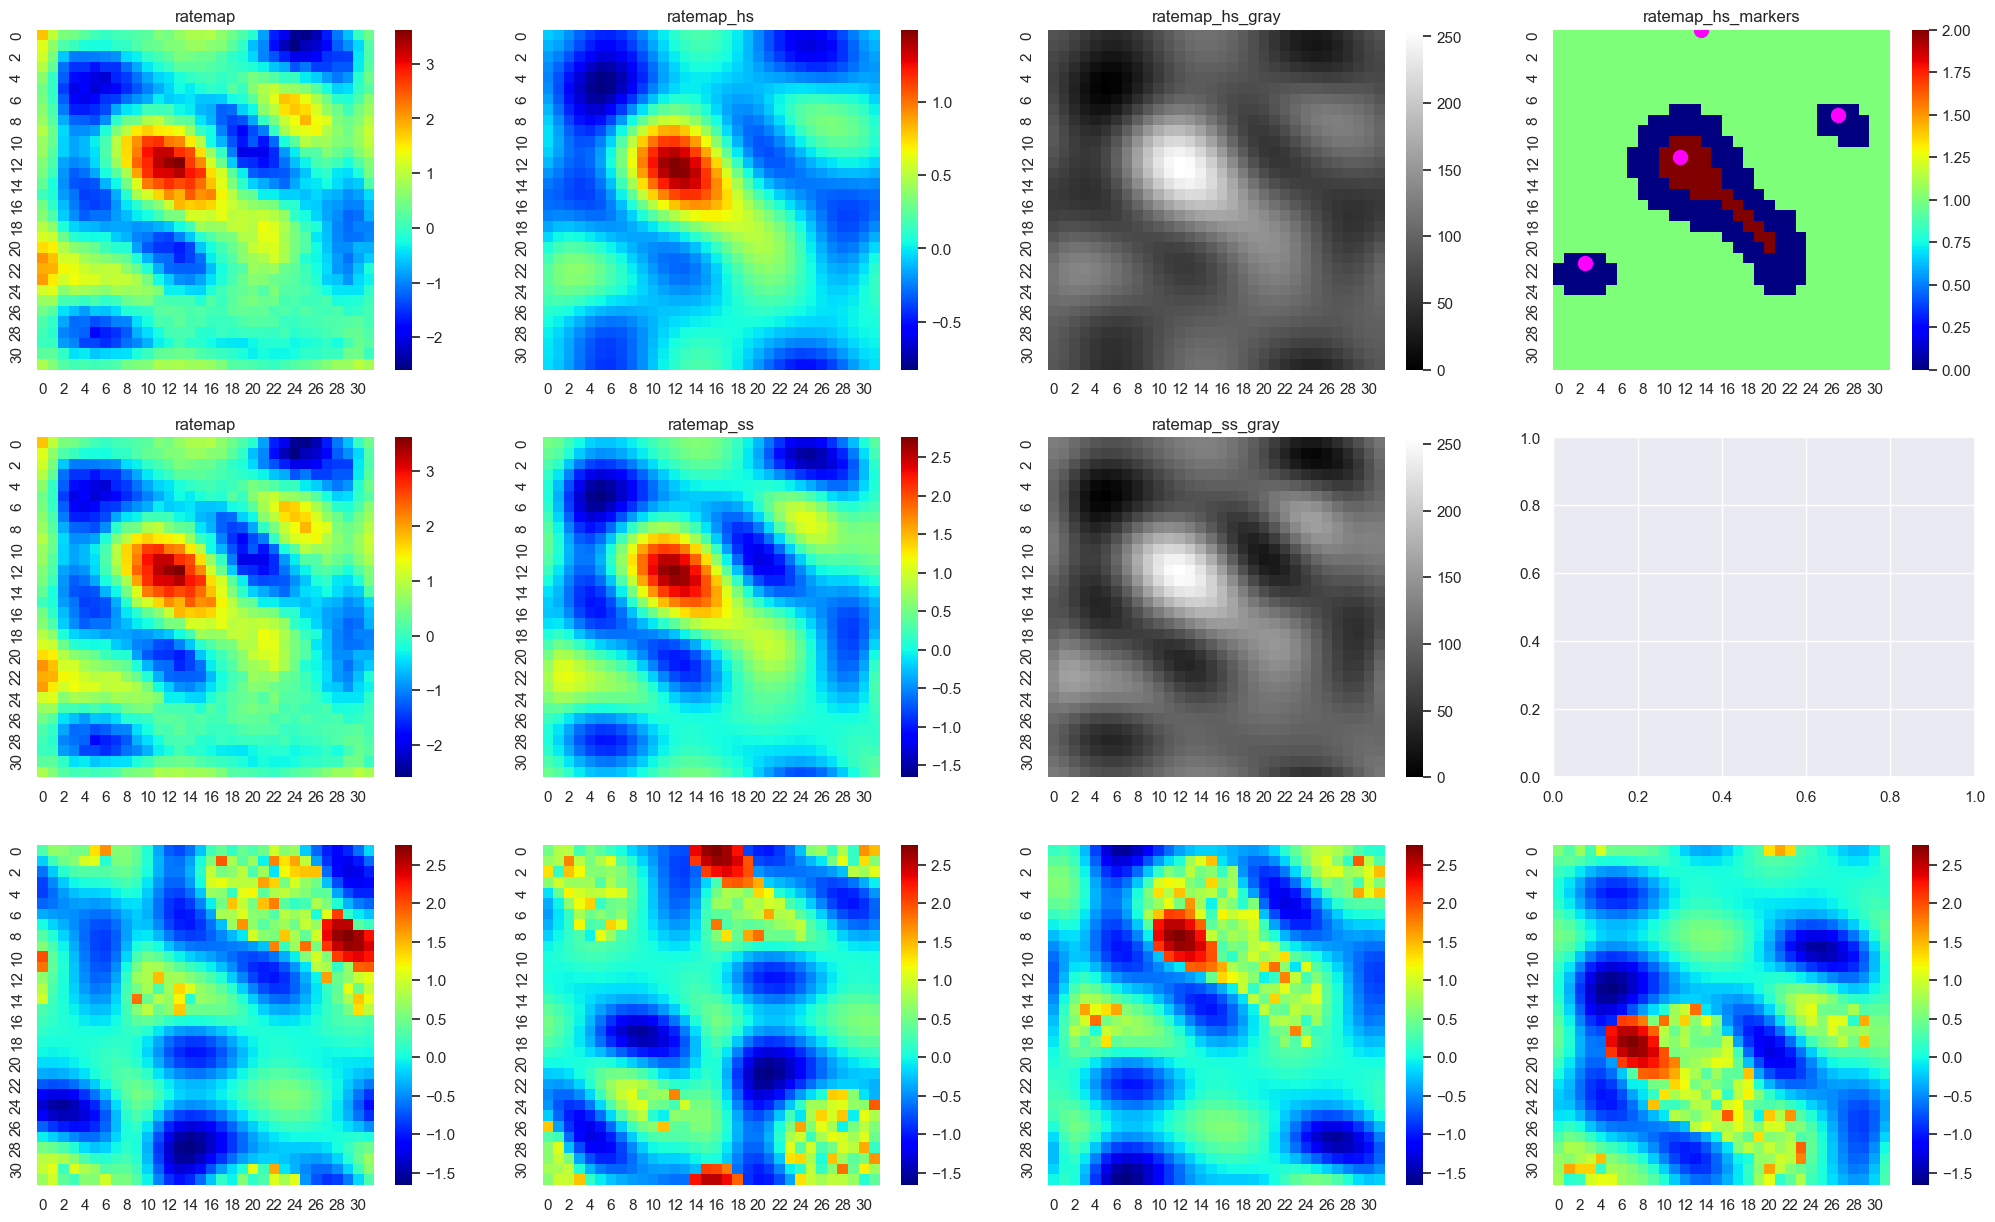

In [13]:
""" 

    viz

"""

sample_idx = np.random.randint( 0, ratemap_mat.shape[ 0 ] )

print( f'sample_idx: { sample_idx }' )

fig, ax = plt.subplots( 3, 4, figsize=( 25, 15 ) )

sns.heatmap( ratemap_mat[ sample_idx ], ax=ax[ 0, 0 ], cmap='jet' )
ax[ 0, 0 ].set_title( 'ratemap' )

sns.heatmap( ratemap_hs[ sample_idx ], ax=ax[ 0, 1 ], cmap='jet' )
ax[ 0, 1 ].set_title( 'ratemap_hs' )

sns.heatmap( ratemap_hs_gray[ sample_idx ], ax=ax[ 0, 2 ], cmap='gray' )
ax[ 0, 2 ].set_title( 'ratemap_hs_gray' )

#ax[ 0, 3 ].imshow( ratemap_hs_markers[ sample_idx ] )
sns.heatmap( ratemap_hs_markers[ sample_idx ], ax=ax[ 0, 3 ], cmap='jet' )
ax[ 0, 3 ].set_title( 'ratemap_hs_markers' )

aux = ratemap_hs_local[ sample_idx ]
aux = np.array( aux ).T

ax[0, 3].scatter( aux[1], aux[0], c='fuchsia', s=100 )

sns.heatmap( ratemap_mat[ sample_idx ], ax=ax[ 1, 0 ], cmap='jet' )
ax[ 1, 0 ].set_title( 'ratemap' )

sns.heatmap( ratemap_ss[ sample_idx ], ax=ax[ 1, 1 ], cmap='jet' )
ax[ 1, 1 ].set_title( 'ratemap_ss' )

sns.heatmap( ratemap_ss_gray[ sample_idx ], ax=ax[ 1, 2 ], cmap='gray' )
ax[ 1, 2 ].set_title( 'ratemap_ss_gray' )

aux = ratemap_ss_random[ sample_idx ]

sns.heatmap( aux[ 0 ], ax=ax[ 2, 0 ], cmap='jet' )
sns.heatmap( aux[ 1 ], ax=ax[ 2, 1 ], cmap='jet' )
sns.heatmap( aux[ 2 ], ax=ax[ 2, 2 ], cmap='jet' )
sns.heatmap( aux[ 3 ], ax=ax[ 2, 3 ], cmap='jet' )

plt.show()